# Dynamic Nested Sampling of Jones scalars observables (noisy angular quantities) with uncertainty inference

**Disclaimer: there is an issue where the evidence is not converging with the dynamic sampler in the release candidate for 1.0. This will be fixed. Doing a non-dynamic nested sampling with more num_live_points does indeed converge with arbitrary accuracy to the true value.**

This is a simple physics model where our data, $y$, is modelled as the principle argument of a unitary complexy vector with white noise added, i.e. the phase of a complex RV, $\phi_\nu = K \tau \nu^{-1} + M \eta \nu + \epsilon$

$L(x) = p(y | x) = \mathcal{N}[y \mid \phi_{\rm obs},\sigma^2 \mathbf{I}]$

where $\phi_{\rm obs} = \arg Y$ and $Y \sim \mathcal{N}(e^{i \phi}, \sigma^2 \mathbf{I}_{\mathbb{C}})$

and we take the priors,

$p(\tau) = \mathcal{C}[\tau \mid 0, 100]$ (Cauchy)


$p(\eta) = \mathcal{U}[\eta \mid -2, 2]$ (Uniform)


$p(\epsilon) = \mathcal{U}[\epsilon \mid -\pi, \pi]$ (Uniform)


$p(\sigma) = \mathcal{H}[\sigma \mid 0.5]$ (Half-Laplace)





## Overview

We'll cover the following topics:

1. How to define a model using `PriorChain`.
2. How to define _a_ likelihood with angular parameters.
3. How to brute-force compute the evidence for comparison.
4. How to compute Bayesian evidence of your model with **dynamic** nested sampling.
5. How to and plot your results.
6. How to iteratively refine your results until you're happy with the precision.

In [1]:
from jaxns import NestedSampler
from jaxns import plot_diagnostics, plot_cornerplot
from jaxns import summary, analytic_log_evidence
from jaxns.prior_transforms import UniformPrior, PriorChain, HalfLaplacePrior, CauchyPrior
from jax import jit
from jax import numpy as jnp, random
import pylab as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:

TEC_CONV = -8.4479745  #rad*MHz/mTECU
CLOCK_CONV = (2e-3 * jnp.pi)  #rad/MHz/ns


def wrap(phi):
    return (phi + jnp.pi) % (2 * jnp.pi) - jnp.pi


def generate_data(key, uncert):
    """
    Generate gain data where the phase have a clock const and tec component. This is a model of the impact of the ionosphere on the propagation of radio waves, part of radio interferometry:

    phase[:] = tec * (tec_conv / freqs[:]) + clock * (clock_conv * freqs[:]) + const

    then the gains are:

        gains[:] ~ Normal[{cos(phase[:]), sin(phase[:])}, uncert^2 * I]

    phase_obs[:] = ArcTan[gains.imag, gains.real]

    Args:
        key:
        uncert: uncertainty of the gains

    Returns:
        phase_obs, freqs
    """
    freqs = jnp.linspace(121, 166, 24)  #MHz
    tec = 90.  #mTECU
    const = 2.  #rad
    clock = 0.5  #ns
    phase = wrap(tec * (TEC_CONV / freqs) + clock * (CLOCK_CONV * freqs) + const)
    Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
    Y_obs = Y + uncert * random.normal(key, shape=Y.shape)
    phase_obs = jnp.arctan2(Y_obs[..., freqs.size:], Y_obs[..., :freqs.size])
    return phase, phase_obs, freqs


INFO[2022-04-10 12:27:58,804]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-04-10 12:27:58,804]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-04-10 12:27:58,805]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-04-10 12:27:58,805]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


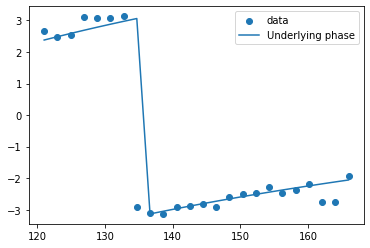

In [3]:
# Generate data
key = random.PRNGKey(43)
key, data_key = random.split(key)
phase_underlying, phase_obs, freqs = generate_data(data_key, 0.25)
plt.scatter(freqs, phase_obs, label='data')
plt.plot(freqs, phase_underlying, label='Underlying phase')
plt.legend()
plt.show()
# Note: the phase wrapping makes this a difficult problem to solve. As we'll see, the posterior is rather complicated.

In [4]:

def log_normal(x, mean, scale):
    dx = (x - mean) / scale
    return -0.5 * jnp.log(2. * jnp.pi) - jnp.log(scale) - 0.5 * dx * dx


def log_likelihood(tec, const, clock, uncert):
    phase = tec * (TEC_CONV / freqs) + const + clock * (CLOCK_CONV * freqs)
    logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., uncert)
    return jnp.sum(logL)


with PriorChain() as prior_chain:
    CauchyPrior('tec', 0., 100.)
    UniformPrior('const', -jnp.pi, jnp.pi)
    UniformPrior('clock', -2., 2.)
    HalfLaplacePrior('uncert', 0.5)

In [5]:
# The analytic evidence, from brute-force calculation (warning uses > 2GB RAM)
log_Z = analytic_log_evidence(prior_chain, log_likelihood, S=60)

print(f"True log(Z): {log_Z}")

True log(Z): -4.740497589111328


In [6]:
# We'll use dynamic nested sampling
ns = NestedSampler(log_likelihood, prior_chain, dynamic=True)

# We'll be interested in also refining the solution later, so we'll also return the state.
# Since return_state invokes a python switch, we need to make it a static argument when jit-compiling.
# For a dynamic goal, we'll to minimise evidence uncertainty, G -> 0.
# For a dynamic termination condition, we'll start with log_Z uncertainty < 0.1

results, state = ns(key,
                 G=0.,
                 termination_evidence_uncert=0.05,
                 return_state=True,
                   adaptive_evidence_stopping_threshold=0.05,
                    adaptive_evidence_patience=1)


WARNING[2022-04-10 12:28:01,826]: Increasing max_samples (100000) by 400 to evenly divide samples_per_step
WARNING[2022-04-10 12:28:01,843]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.


In [7]:
#Let's look at what we have so far.
summary(results)

--------
Termination Conditions:
Evidence uncertainty low enough
--------
# likelihood evals: 7544197
# samples: 21200
# likelihood evals / sample: 355.9
--------
logZ=-4.626 +- 0.069
H=44.0
ESS=3748
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: -0.2 +- 1.1 | -1.1 / -0.8 / 1.6 | -0.9 | -1.8
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: 1.7 +- 1.8 | -1.4 / 2.7 / 3.1 | 2.7 | -1.5
--------
tec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tec: 74.0 +- 15.0 | 49.0 / 81.0 / 87.0 | 79.0 | 101.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.214 +- 0.034 | 0.177 / 0.209 / 0.258 | 0.178 | 0.185
--------


'--------\nTermination Conditions:\nEvidence uncertainty low enough\n--------\n# likelihood evals: 7544197\n# samples: 21200\n# likelihood evals / sample: 355.9\n--------\nlogZ=-4.626 +- 0.069\nH=44.0\nESS=3748\n--------\nclock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nclock: -0.2 +- 1.1 | -1.1 / -0.8 / 1.6 | -0.9 | -1.8\n--------\nconst: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nconst: 1.7 +- 1.8 | -1.4 / 2.7 / 3.1 | 2.7 | -1.5\n--------\ntec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\ntec: 74.0 +- 15.0 | 49.0 / 81.0 / 87.0 | 79.0 | 101.0\n--------\nuncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nuncert: 0.214 +- 0.034 | 0.177 / 0.209 / 0.258 | 0.178 | 0.185\n--------'

In [8]:
# We can look at how each iteration reduced evidence uncertainty. It looks like the evidence is going down slowly.
results.thread_stats.evidence_uncert

DeviceArray([0.        , 0.67086077, 0.52604824, 0.35637575, 0.23257364,
             0.19330758, 0.19057487, 0.19039463, 0.1904372 , 0.19049227,
             0.19046974, 0.15471198, 0.13669258, 0.12563165, 0.11620273,
             0.10950135, 0.10260182, 0.0978538 , 0.09395196, 0.09122631,
             0.08823446, 0.08512354, 0.08303796, 0.07950442, 0.07813416,
             0.07484414, 0.07503662, 0.07285052, 0.07092695, 0.06846915,
             0.06820574, 0.0664224 , 0.06446237, 0.06354226, 0.0624313 ,
             0.06122237, 0.06204439, 0.06019935, 0.05867101, 0.05828164,
             0.05818338, 0.05629228, 0.05565764, 0.05487899, 0.05528802,
             0.05519306, 0.05432006, 0.05331888, 0.05236461, 0.05234867,
             0.05279989, 0.05029534, 0.04997911, 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.

WARNING[2022-04-10 12:28:32,060]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING[2022-04-10 12:28:32,583]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


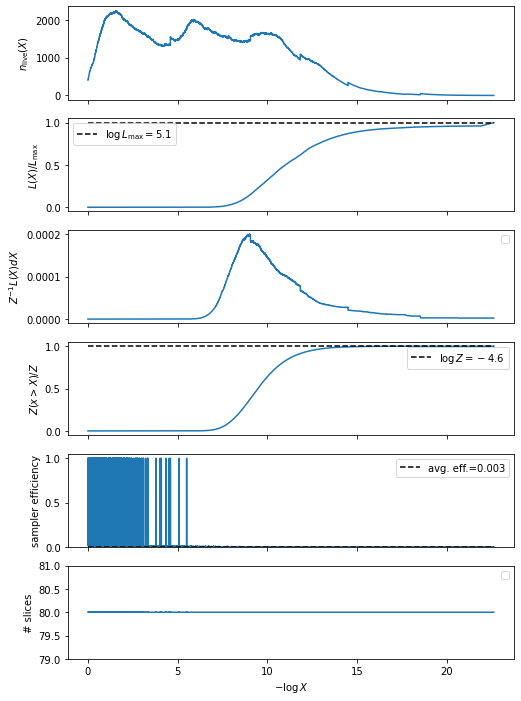

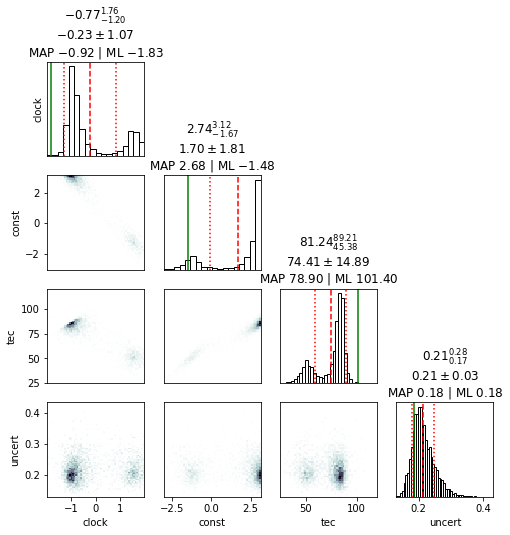

In [9]:
# Finally let's look at the results.
plot_diagnostics(results)
plot_cornerplot(results)

# We can see that the sampler focused more on the initial part of the enclosed prior volume when -logX < 7.5.
# This is evident in the increased n_live points.